# Data Access Methods

**Leonardo Laiolo**

**Australian Ocean Data Network ([AODN](https://imos.org.au/facilities/aodn))**

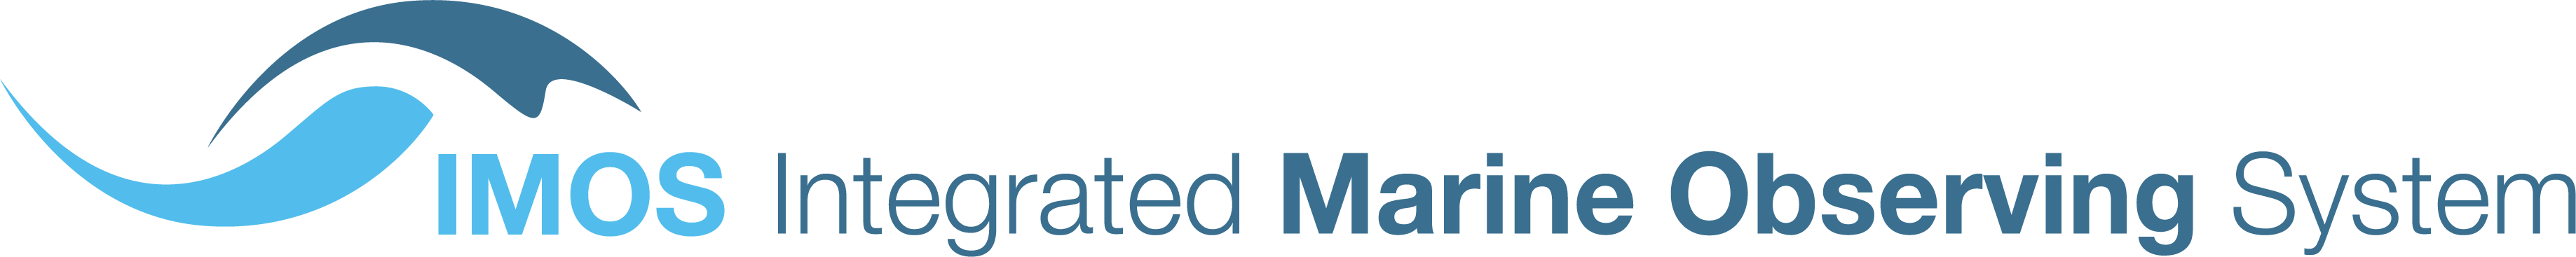

This tutorial demostrates several ways data can be accessed remotely and loaded into a Python environment, including

* OPeNDAP
* OGC Web Feature Service (WFS)
* direct access to files on cloud storage (AWS S3)
* cloud-optimised formats Zarr & Parquet

The examples here use data from Australia's Integrated Marine Observing System (IMOS).
These can be browsed and accessed via the [AODN Portal](https://portal.aodn.org.au/), the [IMOS Metadata Catalogue](https://catalogue-imos.aodn.org.au/), or the [IMOS THREDDS Server](https://thredds.aodn.org.au/thredds/catalog/IMOS/catalog.html). Each data collection's metadata record includes more specific links to the relevant THREDDS folders, and WFS services.

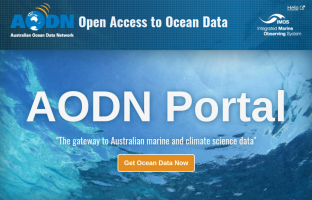  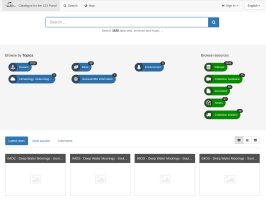

In [1]:
# Import all the tools we need...
import os
import requests

# For working with data
import pandas as pd
import xarray as xr

# For data that may be larger than the memory available on your computer...
import dask
import dask.dataframe as dd

# For accessing OGC Web Feature Service
from owslib.wfs import WebFeatureService

# For accessing AWS S3 cloud storage
import s3fs

# Cloud optimised data
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import pyarrow.compute as pc

# Plotting tools
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import hvplot.dask
# For plotting geographic data & maps
import geoviews as gv
import geoviews.feature as gf
from geoviews import opts
from cartopy import crs

## Use Matplotlib backend for web preview of notebook
## Comment out these lines to get the default interactive plots using Bokeh
hvplot.extension('matplotlib', compatibility='bokeh')
gv.extension('matplotlib')
gv.output(size=200)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
# Set up local data path
DATA_BASEPATH = "/g/data/nf33/public/ohw_data/IMOS"

# The old school way

The old (and still common) way to access data is to first download it to your computer and read it from there. 
This is easy for small datasets, but not always ideal:
* What if the data is bigger than your hard disk?
* What if you only need a small fraction of a dataset?
* What if the dataset is routinely updated and you want to re-run your analysis on the latest data?
* What if you want to run your analysis on another computer or in the cloud?

These days it is often more convenient to have data managed in a central location and access it remotely.
There are many ways this can be done. In this tutorial we will look at a few of the common ones, and a ccuple of the newer ones.

# OPeNDAP

* [OPeNDAP](https://www.opendap.org/about) stands for "Open-source Project for a Network Data Access Protocol"
* Provides access to metadata and data subsets via the Web without downloading an entire dataset
* Many tools that can read NetCDF files can also talk to an OPeNDAP URL directly

In Python, we can simply open the URL with `xarray`, then proceed with our analysis using the resulting `Dataset` object.

Here we use an example from the [AODN THREDDS server](https://thredds.aodn.org.au/thredds/catalog.html).

In [3]:
opendap_url = ("https://thredds.aodn.org.au/thredds/dodsC/"
               "IMOS/ANMN/NSW/PH100/gridded_timeseries/"
               "IMOS_ANMN-NSW_TZ_20091029_PH100_FV02_TEMP-gridded-timeseries_END-20240723_C-20240810.nc")

# You can preview the file's metadata in your browser by adding ".html" to the above URL
print(opendap_url + ".html")

https://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NSW/PH100/gridded_timeseries/IMOS_ANMN-NSW_TZ_20091029_PH100_FV02_TEMP-gridded-timeseries_END-20240723_C-20240810.nc.html


In [4]:
# Xarray is a good library for working with labeled multi-dimensional arrays
# open_dataset allows users to access remote datasets, without needing to download files locally
ds_mooring = xr.open_dataset(opendap_url)
ds_mooring

<xarray.Dataset> Size: 7MB
Dimensions:     (TIME: 126952, DEPTH: 12)
Coordinates:
  * DEPTH       (DEPTH) float32 48B 0.0 10.0 20.0 30.0 ... 80.0 90.0 100.0 110.0
  * TIME        (TIME) datetime64[ns] 1MB 2009-10-29T03:00:00 ... 2024-07-23T...
    LONGITUDE   float64 8B ...
    LATITUDE    float64 8B ...
Data variables:
    TEMP_count  (TIME) int16 254kB ...
    TEMP        (TIME, DEPTH) float32 6MB ...
Attributes: (12/42)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Gridded Time Series Product: This file con...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Australian Ocean Data Network (AODN)
    author_email:                  info@aodn.org.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    source_file_download:          https://s3-ap-southeast-2.amazonaws.com/im...
    source_file_opendap:           http://thredds.aodn.org.au/thredds/dodsC/I...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2024-07-23T23:00:00Z
    time_coverage_start:           2009-10-29T03:00:00Z
    title:                         Gridded Time Series Product: TEMP interpol...

In [5]:
print(ds_mooring.title)

Gridded Time Series Product: TEMP interpolated at PH100 to fixed target depths at 1-hour time intervals, between 2009-10-29T03:00:00Z and 2024-07-23T23:00:00Z and 0 and 110 meters.


This dataset is derived from repeated deployments of moored temperature loggers, binned to hourly intervals and interpolated to a fixed set of target depths. See the file metadata, or the associated [metadata record](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/279a50e3-21a5-4590-85a0-71f963efab82) for more info.

:Scatter   [TIME]   (DEPTH,TEMP)
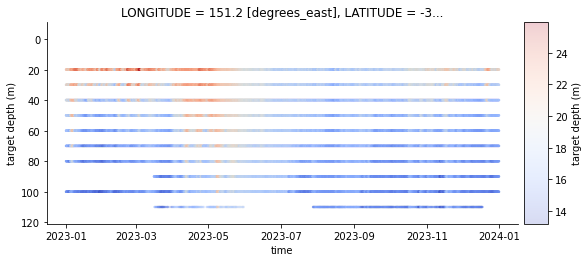

In [6]:
# Plotting data directly from the remote source 
# Hourly averages x 12 depths x 13+ yr = over a million points to plot!
# Let's just look at a year's worth to speed things up...
ds_mooring.sel(TIME="2023").hvplot.scatter(x="TIME", y="DEPTH", c="TEMP",
                                           cmap="coolwarm", alpha=0.2,
                                           flip_yaxis=True, hover=False)

:Curve   [TIME]   (TEMP)
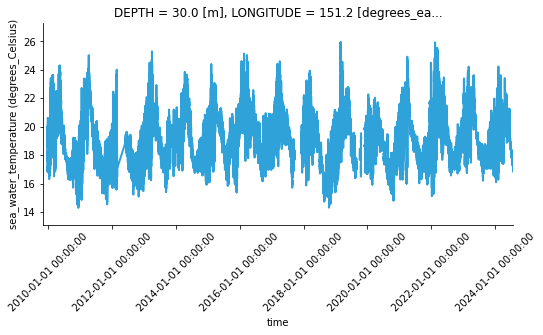

In [7]:
# ...or we can look at the full timeseries of temperature at one single depth 
ds_mooring.TEMP.sel(DEPTH=30).hvplot().opts(xrotation=45)

### Another way to quickly check the data
You can also check the [dataset](https://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NSW/PH100/gridded_timeseries/IMOS_ANMN-NSW_TZ_20091029_PH100_FV02_TEMP-gridded-timeseries_END-20240723_C-20240810.nc.html) and the NetCDF file content in the OPeNDAP Access Form.

# Web Feature Service (WFS)

* A [standard](http://www.opengeospatial.org/standards/wfs) of the [Open Geospatial Consortium](http://www.opengeospatial.org/) (OGC)
* Allows tabular geospatial data to be accessed via the Web.
* A _feature_ has a _geometry_ (e.g. a point/line/polygon) indicating a geographic location, and a set of properties (e.g. temperature) 
* WFS allows filtering based on geometry or properties.
* In Python WFS and other OGC Web Services (OWS) can be accessed using the [`owslib`](https://pypi.org/project/OWSLib/) library

For example, most of the tabular hosted by the AODN is available via WFS.

In [8]:
# Access AODN WFS
wfs = WebFeatureService(url="https://geoserver-123.aodn.org.au/geoserver/wfs",
                        version="1.1.0")
wfs.identification.title

'AODN Web Feature Service (WFS)'

In [9]:
# Each dataset is served as a separate "feature type":
print(f"There are {len(wfs.contents)} feature types, e.g.")
list(wfs.contents)[:10]

There are 398 feature types, e.g.


['imos:anmn_ctd_profiles_data',
 'imos:anmn_ctd_profiles_map',
 'imos:anmn_velocity_timeseries_map',
 'imos:anmn_nrs_rt_meteo_timeseries_data',
 'imos:anmn_nrs_rt_meteo_timeseries_map',
 'imos:anmn_nrs_rt_bio_timeseries_data',
 'imos:anmn_nrs_rt_bio_timeseries_map',
 'imos:anmn_nrs_rt_wave_timeseries_data',
 'imos:anmn_nrs_rt_wave_timeseries_map',
 'imos:anmn_acoustics_map']

More information can be found on [metadata catalogues](https://imos.org.au/data/access-ocean-data/metadata-catalogues). 
Connet to [IMOS GeoNetwork](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/home) and paste the name of the Geoserver layer (e.g., `anmn_ctd_profiles_data`) to look at the metadata or use the search tool to look for any specific dataset.

Let's have a closer look at the `anmn_ctd_profiles_data` feature. In this example we'll look at a dataset containing condicutivity-temperature-depth (CTD) profiles obtained at the National Reference Stations around Australia ([here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/7b901002-b1dc-46c3-89f2-b4951cedca48)'s the detailed metadata record)

In [10]:
typename = 'imos:anmn_ctd_profiles_data'
wfs.get_schema(typename)['properties']

{'file_id': 'int',
 'site_code': 'string',
 'cruise_id': 'string',
 'time_coverage_start': 'dateTime',
 'time_coverage_end': 'dateTime',
 'TIME': 'dateTime',
 'INSTANCE': 'int',
 'DIRECTION': 'string',
 'TIME_quality_control': 'string',
 'LATITUDE': 'double',
 'LATITUDE_quality_control': 'string',
 'LONGITUDE': 'double',
 'LONGITUDE_quality_control': 'string',
 'DEPTH': 'float',
 'DEPTH_quality_control': 'string',
 'BOT_DEPTH': 'float',
 'BOT_DEPTH_quality_control': 'string',
 'PRES_REL': 'float',
 'PRES_REL_quality_control': 'string',
 'TEMP': 'float',
 'TEMP_quality_control': 'string',
 'PSAL': 'float',
 'PSAL_quality_control': 'string',
 'DOX2': 'float',
 'DOX2_quality_control': 'string',
 'TURB': 'float',
 'TURB_quality_control': 'string',
 'CHLF': 'float',
 'CHLF_quality_control': 'string',
 'CHLU': 'float',
 'CHLU_quality_control': 'string',
 'CPHL': 'float',
 'CPHL_quality_control': 'string',
 'CNDC': 'float',
 'CNDC_quality_control': 'string',
 'DESC': 'float',
 'DESC_quality_c

We can read in a subset of the data by specifying a bounding box (in this case near Sydney, Australia).
We'll get the result in CSV format so it's easy to read into a Pandas DataFrame.

First we'll ask for just 10 features, for a quick look at the data.

In [11]:
xmin, xmax = 151.2, 151.25   # Port Hacking, near Sydney, NSW
ymin, ymax = -34.2, -34.1

response = wfs.getfeature(typename=typename,
                          bbox=(xmin, ymin, xmax, ymax),
                          maxfeatures=10,
                          outputFormat='csv')
df = pd.read_csv(response)
response.close()

df

,FID,file_id,site_code,cruise_id,time_coverage_start,time_coverage_end,TIME,INSTANCE,DIRECTION,TIME_quality_control,...,CHLU_quality_control,CPHL,CPHL_quality_control,CNDC,CNDC_quality_control,DESC,DESC_quality_control,DENS,DENS_quality_control,geom
0,anmn_ctd_profiles_data.fid-5a0fb5f_1917837556f...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6266,0,0.228,0,1025.8478,0,POINT (-34.1161666667 151.218)
1,anmn_ctd_profiles_data.fid-5a0fb5f_1917837556f...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6246,0,0.574,0,1025.8652,0,POINT (-34.1161666667 151.218)
2,anmn_ctd_profiles_data.fid-5a0fb5f_1917837556f...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6224,0,0.741,0,1025.8737,0,POINT (-34.1161666667 151.218)
3,anmn_ctd_profiles_data.fid-5a0fb5f_1917837556f...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6190,0,0.803,0,1025.8790,0,POINT (-34.1161666667 151.218)
4,anmn_ctd_profiles_data.fid-5a0fb5f_1917837556f...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6138,0,0.749,0,1025.8892,0,POINT (-34.1161666667 151.218)
5,anmn_ctd_profiles_data.fid-5a0fb5f_1917837556f...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6089,0,0.687,0,1025.9072,0,POINT (-34.1161666667 151.218)
6,anmn_ctd_profiles_data.fid-5a0fb5f_1917837556f...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6067,0,0.722,0,1025.9241,0,POINT (-34.1161666667 151.218)
7,anmn_ctd_profiles_data.fid-5a0fb5f_1917837556f...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6048,0,0.773,0,1025.9321,0,POINT (-34.1161666667 151.218)
8,anmn_ctd_profiles_data.fid-5a0fb5f_1917837556f...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6023,0,0.788,0,1025.9385,0,POINT (-34.1161666667 151.218)
9,anmn_ctd_profiles_data.fid-5a0fb5f_1917837556f...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.5982,0,0.846,0,1025.9432,0,POINT (-34.1161666667 151.218)


We can also filter the data based on the values in specified columns (properties) and ask for only a subset of the columns to be returned. The filters need to be provided in XML format, but the `owslib` library allows us to construct them in a more Pythonic way.

Here we select only the profiles associated with the Port Hacking 100m mooring site, and only the data points flagged as "good data" by automated quality-control procedures.

In [12]:
from owslib.etree import etree
from owslib.fes import PropertyIsEqualTo, And

filter = And([PropertyIsEqualTo(propertyname="site_code", literal="PH100"),
              PropertyIsEqualTo(propertyname="PRES_REL_quality_control", literal="1"),
              PropertyIsEqualTo(propertyname="TEMP_quality_control", literal="1"),
              PropertyIsEqualTo(propertyname="PSAL_quality_control", literal="1"),
              PropertyIsEqualTo(propertyname="CPHL_quality_control", literal="1")
             ])
filterxml = etree.tostring(filter.toXML(), encoding="unicode")

response = wfs.getfeature(typename=typename, filter=filterxml, outputFormat="csv",
                          propertyname=["TIME", "DEPTH", "TEMP", "PSAL", "CPHL"]
                         )
df = pd.read_csv(response, parse_dates=["TIME"])
response.close()

# the server adds a feature ID column we don't really need
df.drop(columns='FID', inplace=True)

In [13]:
df

,TIME,DEPTH,TEMP,PSAL,CPHL
0,2014-12-08 22:28:54,1.986,21.6432,35.5080,0.9365
1,2014-12-08 22:28:54,2.979,21.6441,35.5085,0.9560
2,2014-12-08 22:28:54,3.971,21.6417,35.5085,0.9644
3,2014-12-08 22:28:54,4.964,21.6314,35.5089,0.9963
4,2014-12-08 22:28:54,5.957,21.6077,35.5102,0.9844
...,...,...,...,...,...
12117,2024-05-16 00:40:07,96.285,16.8342,35.4839,0.0349
12118,2024-05-16 00:40:07,97.277,16.8212,35.4806,0.0642
12119,2024-05-16 00:40:07,98.270,16.8153,35.4793,0.0789
12120,2024-05-16 00:40:07,99.263,16.8131,35.4787,0.0690


:Layout
   .NdOverlay.I   :NdOverlay   [TIME]
      :Curve   [TEMP]   (DEPTH)
   .NdOverlay.II  :NdOverlay   [TIME]
      :Curve   [PSAL]   (DEPTH)
   .NdOverlay.III :NdOverlay   [TIME]
      :Curve   [CPHL]   (DEPTH)
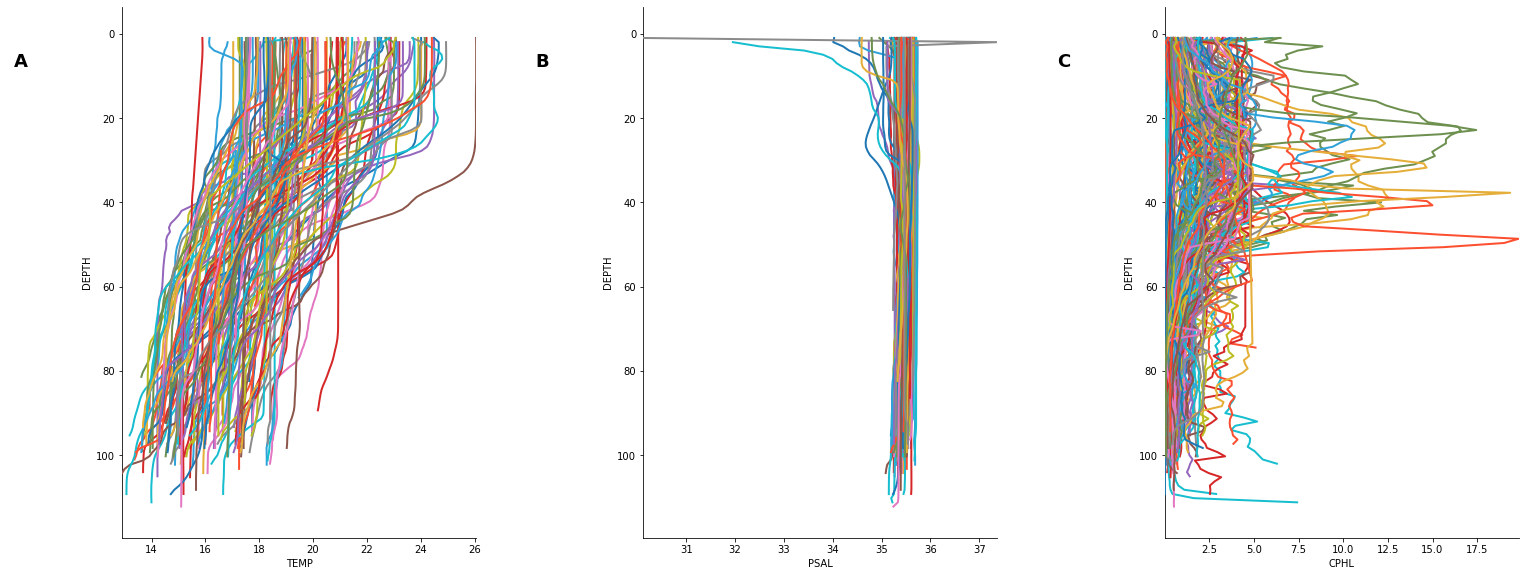

In [14]:
# We can explore the temperature, salinity and chlorophyll profiles
# Change "by" to "groupby" to view one profile at a time, with time selected interactively
temp_plot = df.hvplot(x="TEMP", y="DEPTH", by="TIME", flip_yaxis=True, legend=False, width=200)
psal_plot = df.hvplot(x="PSAL", y="DEPTH", by="TIME", flip_yaxis=True, legend=False, width=200)
cphl_plot = df.hvplot(x="CPHL", y="DEPTH", by="TIME", flip_yaxis=True, legend=False, width=200)

(temp_plot + psal_plot + cphl_plot).opts(tight=True)

:Overlay
   .Curve.I   :Curve   [TIME]   (TEMP)
   .Scatter.I :Scatter   [TIME]   (TEMP)
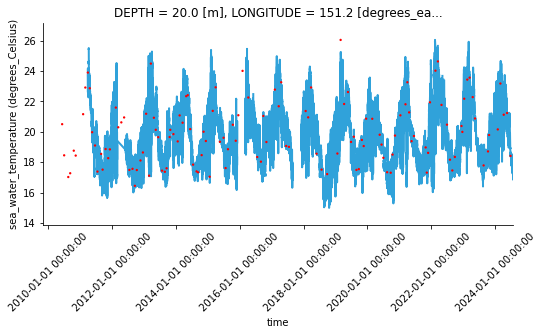

In [15]:
# We can also extract the temperature measurements at a fixed depth and compare to the timeseries from the mooring 
comp_depth = 20  # metres

df_sub = df[df.DEPTH.round() == comp_depth]
ctd_plot = df_sub.hvplot.scatter(x="TIME", y="TEMP", c="red")

mooring_plot = ds_mooring.TEMP.sel(DEPTH=comp_depth).hvplot().opts(xrotation=45)

mooring_plot * ctd_plot

# Direct access to files on cloud storage

Data files made available to the public on cloud storage such as [Amazon S3](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html) (Simple Storage Service) can be accessed over the web as if they were stored locally. You just need to find the exact URL for each file.

In Python, we can access S3 storage in a very similar way to a local filesystem using the `s3fs` library.

For example, all the public data files hosted by the Australian Ocean Data Network are stored in an [S3 bucket](https://www.techtarget.com/searchaws/definition/AWS-bucket) called `imos-data`. You can browse the contents of the bucket and download individual files [here](https://imos-data.aodn.org.au). 

Below we'll look at a [high-resolution regional SST product](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/a4170ca8-0942-4d13-bdb8-ad4718ce14bb) from IMOS (based on satellite and in-situ observations). This product is a collection of daily gridded NetCDF files covering the Australian region.

In [16]:
# Create a connection to S3 
s3 = s3fs.S3FileSystem(anon=True)

# List the most recent files available
sst_files = s3.ls("imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023")
sst_files[-20:]

['imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20231212120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20231213120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20231214120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20231215120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20231216120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20231217120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20231218120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20231219120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/202312201

In [17]:
# Open the latest file and look at its contents
ds = xr.open_dataset(s3.open(sst_files[-1]))
ds

<xarray.Dataset> Size: 47MB
Dimensions:           (time: 1, lat: 1081, lon: 1561)
Coordinates:
  * time              (time) datetime64[ns] 8B 2023-12-31T12:00:00
  * lat               (lat) float32 4kB -70.0 -69.92 -69.83 ... 19.83 19.92 20.0
  * lon               (lon) float32 6kB 60.0 60.08 60.17 ... 189.8 189.9 190.0
Data variables:
    sea_ice_fraction  (time, lat, lon) float64 13MB ...
    analysed_sst      (time, lat, lon) float64 13MB ...
    analysis_error    (time, lat, lon) float64 13MB ...
    mask              (time, lat, lon) float32 7MB ...
    crs               int32 4B ...
Attributes: (12/65)
    id:                         RAMSSA_09km-ABOM-L4-AUS-v01
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    title:                      RAMSSA v1.1 Analysed high resolution foundati...
    summary:                    AMSR2-JAXA nobs=****** obsesd: avg=0.692 min=...
    source:                     AMSR2-JAXA,AVHRRMTB_G-NAVO,VIIRS_NPP_OSPO,VII...
    references:                 Beggs H., A. Zhong, G. Warren, O. Alves, G. B...
    ...                         ...
    geospatial_lat_max:         20.0
    geospatial_lat_min:         -70.0
    geospatial_lon_max:         190.0
    geospatial_lon_min:         60.0
    geospatial_bounds:          POLYGON((-70 60, 20 60, 20 190, -70 190, -70 ...
    geospatial_bounds_crs:      EPSG:4326

:Overlay
   .Image.I :Image   [lon,lat]   (analysed_sst)
   .Land.I  :Feature   [Longitude,Latitude]
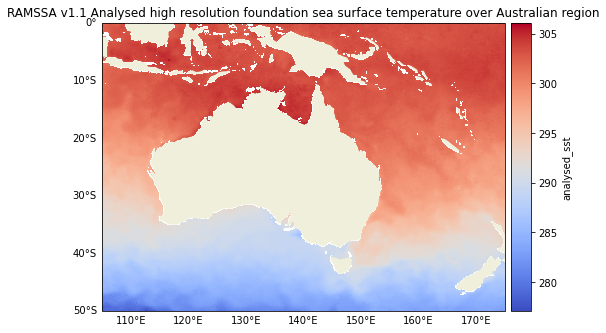

In [18]:
# Plot a subset of the dataset around Australia
sst_var = 'analysed_sst'
gds = gv.Dataset(ds.sel(lat=slice(-50, 0), lon=slice(105, 175)),
                 kdims=['lon', 'lat'],
                 vdims=[sst_var]
                )
sst_plot = (gds.to(gv.Image)
               .opts(cmap='coolwarm', colorbar=True, aspect=1.4, title=ds.title))
sst_plot * gf.land

It's worth understanding a little about how this works. 

The above example only makes use of the metadata from the file, one data variables, and the `lon` and `lat` coordinates. On a local filesystem, it would be easy to read only these specific parts of the file from disk. 

However, on cloud storage services like S3 (also called "object storage") the basic read/write functions operate on the entire file (object), so at least in the backend, the entire file is read**. If you only need a small subset of a large file, this can be a very inefficient way to get it.

** _Note: it is possible to request only a subset of an S3 object to be read, but this is more advanced usage than what we're doing here._

For example, if we wanted to plot a timeseries of the above satellite SST product at a given point, we would only need a single value out of each file (corresponding to one point in the timeseries), but the entire file would need to be read each time.

For a quick demo we'll try this with a full month's files. `xarray` has a handy `open_mfdataset` function that can create a single `Dataset` object out of a series of files (with similar structure).

In [19]:
%%time
s3_objs = [s3.open(f)
           for f in s3.glob("imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/202307*")
          ]
mds = xr.open_mfdataset(s3_objs, engine="h5netcdf")
mds

CPU times: user 7.48 s, sys: 406 ms, total: 7.88 s
Wall time: 48.8 s


<xarray.Dataset> Size: 1GB
Dimensions:           (time: 30, lat: 1081, lon: 1561)
Coordinates:
  * time              (time) datetime64[ns] 240B 2023-07-01T12:00:00 ... 2023...
  * lat               (lat) float32 4kB -70.0 -69.92 -69.83 ... 19.83 19.92 20.0
  * lon               (lon) float32 6kB 60.0 60.08 60.17 ... 189.8 189.9 190.0
Data variables:
    sea_ice_fraction  (time, lat, lon) float64 405MB dask.array<chunksize=(1, 1081, 1561), meta=np.ndarray>
    analysed_sst      (time, lat, lon) float64 405MB dask.array<chunksize=(1, 1081, 1561), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 405MB dask.array<chunksize=(1, 1081, 1561), meta=np.ndarray>
    mask              (time, lat, lon) float32 202MB dask.array<chunksize=(1, 1081, 1561), meta=np.ndarray>
    crs               (time) int32 120B -2147483647 -2147483647 ... -2147483647
Attributes: (12/65)
    id:                         RAMSSA_09km-ABOM-L4-AUS-v01
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    title:                      RAMSSA v1.1 Analysed high resolution foundati...
    summary:                    AMSR2-JAXA nobs=****** obsesd: avg=0.693 min=...
    source:                     AMSR2-JAXA,AVHRRMTB_G-NAVO,VIIRS_NPP_OSPO,VII...
    references:                 Beggs H., A. Zhong, G. Warren, O. Alves, G. B...
    ...                         ...
    geospatial_lat_max:         20.0
    geospatial_lat_min:         -70.0
    geospatial_lon_max:         190.0
    geospatial_lon_min:         60.0
    geospatial_bounds:          POLYGON((-70 60, 20 60, 20 190, -70 190, -70 ...
    geospatial_bounds_crs:      EPSG:4326

The variables in the dataset are not loaded into memory (they're still `dask.array`). However, in the background, each complete file had to be downloaded from S3 before the metadata needed by `open_mfdataset` could be read. 

In [20]:
mds.analysed_sst

<xarray.DataArray 'analysed_sst' (time: 30, lat: 1081, lon: 1561)> Size: 405MB
dask.array<concatenate, shape=(30, 1081, 1561), dtype=float64, chunksize=(1, 1081, 1561), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 240B 2023-07-01T12:00:00 ... 2023-07-31T12...
  * lat      (lat) float32 4kB -70.0 -69.92 -69.83 -69.75 ... 19.83 19.92 20.0
  * lon      (lon) float32 6kB 60.0 60.08 60.17 60.25 ... 189.8 189.9 190.0
Attributes:
    valid_min:              -300
    valid_max:              4500
    clip_min:               269.30999398231506
    clip_max:               304.8399931881577
    units:                  kelvin
    long_name:              analysed sea surface temperature
    standard_name:          sea_surface_foundation_temperature
    comment:                Optimally interpolated analysis of SST observations.
    source:                 AMSR2-JAXA,AVHRRMTB_G-NAVO,VIIRS_NPP_OSPO,VIIRS_N...
    coverage_content_type:  physicalMeasurement
    grid_mapping:           crs

Let's compare this to reading the same files from a local filesystem...

In [21]:
%%time
from glob import glob
local_files = glob(os.path.join(DATA_BASEPATH, "RAMSSA", "*"))

mds = xr.open_mfdataset(local_files, engine="h5netcdf")
mds

CPU times: user 6.32 s, sys: 142 ms, total: 6.46 s
Wall time: 8.6 s


<xarray.Dataset> Size: 1GB
Dimensions:           (time: 30, lat: 1081, lon: 1561)
Coordinates:
  * time              (time) datetime64[ns] 240B 2023-07-01T12:00:00 ... 2023...
  * lat               (lat) float32 4kB -70.0 -69.92 -69.83 ... 19.83 19.92 20.0
  * lon               (lon) float32 6kB 60.0 60.08 60.17 ... 189.8 189.9 190.0
Data variables:
    sea_ice_fraction  (time, lat, lon) float64 405MB dask.array<chunksize=(1, 1081, 1561), meta=np.ndarray>
    analysed_sst      (time, lat, lon) float64 405MB dask.array<chunksize=(1, 1081, 1561), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 405MB dask.array<chunksize=(1, 1081, 1561), meta=np.ndarray>
    mask              (time, lat, lon) float32 202MB dask.array<chunksize=(1, 1081, 1561), meta=np.ndarray>
    crs               (time) int32 120B -2147483647 -2147483647 ... -2147483647
Attributes: (12/65)
    id:                         RAMSSA_09km-ABOM-L4-AUS-v01
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    title:                      RAMSSA v1.1 Analysed high resolution foundati...
    summary:                    AMSR2-JAXA nobs=****** obsesd: avg=0.693 min=...
    source:                     AMSR2-JAXA,AVHRRMTB_G-NAVO,VIIRS_NPP_OSPO,VII...
    references:                 Beggs H., A. Zhong, G. Warren, O. Alves, G. B...
    ...                         ...
    geospatial_lat_max:         20.0
    geospatial_lat_min:         -70.0
    geospatial_lon_max:         190.0
    geospatial_lon_min:         60.0
    geospatial_bounds:          POLYGON((-70 60, 20 60, 20 190, -70 190, -70 ...
    geospatial_bounds_crs:      EPSG:4326

Whichever way we loaded the dataset, we can plot it the same way as any other `xarray.Dataset`.

:Curve   [time]   (analysed_sst)
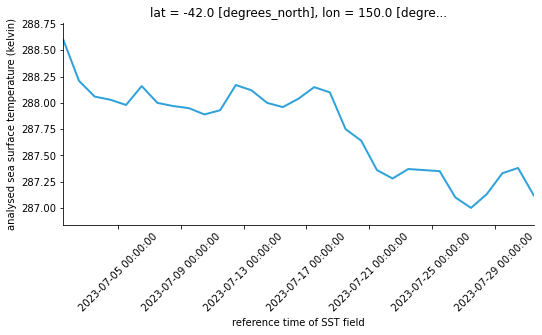

In [22]:
# Plot sst at a specific lat and long for the month
mds[sst_var].sel(lat=-42, lon=150, method="nearest").hvplot().opts(xrotation=45)

## Cloud-optimised data format: Zarr

Zarr is a relatively new data format specifically developed for efficient access to multi-dimensional data in the cloud. 
Unlike traditional formats like NetCDF, Zarr stores data in small, chunked files that can be accessed independently. This chunking allows for faster read and write operations, as only the necessary portions of the dataset are accessed at any given time.

Each Zarr dataset is organized in a standard directory structure, with metadata stored separately from the data chunks. This separation of metadata and data enables the format to be highly scalable, making it suitable for very large datasets.

### Why Use Zarr?

- **Scalability**: Zarr can handle datasets that are too large to fit into memory.
- **Efficiency**: By accessing only the needed chunks, Zarr minimizes data transfer, which is crucial when working with cloud storage.
- **Interoperability**: Zarr works well with tools like `xarray` and `dask`, which support parallel computing and out-of-core operations.



In [23]:
# A Zarr dataset can easily be opened as an xarray.Dataset
# In this case the Zarr store is in an S3 bucket zarr dataset

import fsspec # fsspec allows us to access the Zarr dataset directly from the S3 bucket, 
dataset_name="satellite_ghrsst_l3s_1day_daynighttime_single_sensor_australia"

url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
zds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)
zds

<xarray.Dataset> Size: 23TB
Dimensions:                  (time: 9713, lat: 4500, lon: 6000)
Coordinates:
  * lat                      (lat) float32 18kB 19.99 19.97 ... -69.97 -69.99
  * lon                      (lon) float32 24kB 70.01 70.03 ... 190.0 190.0
  * time                     (time) datetime64[ns] 78kB 2019-01-01T09:20:00 ....
Data variables:
    dt_analysis              (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    l2p_flags                (time, lat, lon) float32 1TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    quality_level            (time, lat, lon) float32 1TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    satellite_zenith_angle   (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sea_surface_temperature  (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sses_bias                (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sses_count               (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sses_standard_deviation  (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_count                (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_dtime                (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_mean                 (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_standard_deviation   (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                      CF-1.6
    Metadata_Conventions:             Unidata Dataset Discovery v1.0
    Metadata_Link:                    TBA
    acknowledgment:                   Any use of these data requires the foll...
    cdm_data_type:                    grid
    comment:                          HRPT AVHRR experimental L3 retrieval pr...
    ...                               ...
    summary:                          A merged, day+night, multi-sensor L3S f...
    time_coverage_end:                20021009T000600Z
    time_coverage_start:              20021007T191706Z
    title:                            IMOS L3S Day and Night gridded multiple...
    uuid:                             9ac89e04-601f-46ef-b2c6-a5f8ede3b892
    westernmost_longitude:            70.01000213623047

In [24]:
# We can then see the chunked structure of the data by looking at one of the variables
zds.sea_surface_temperature

<xarray.DataArray 'sea_surface_temperature' (time: 9713, lat: 4500, lon: 6000)> Size: 2TB
dask.array<open_dataset-sea_surface_temperature, shape=(9713, 4500, 6000), dtype=float64, chunksize=(5, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 18kB 19.99 19.97 19.95 19.93 ... -69.95 -69.97 -69.99
  * lon      (lon) float32 24kB 70.01 70.03 70.05 70.07 ... 189.9 190.0 190.0
  * time     (time) datetime64[ns] 78kB 2019-01-01T09:20:00 ... 2002-10-27T09...
Attributes:
    comment:        An estimate of the foundation temperature of the upper fe...
    long_name:      sea surface foundation temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

:Overlay
   .Image.I     :Image   [lon,lat]   (sea_surface_temperature)
   .Land.I      :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
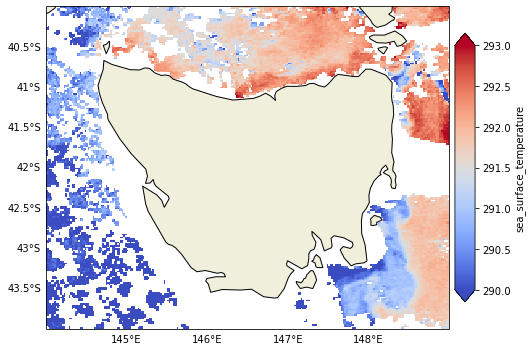

In [29]:
# We can plot Zarr dataset in similar way as the NetCDF-based one

sst_var = 'sea_surface_temperature' 

# Define the time, latitude, and longitude range for the plot
time = '2023-02-01'
lat_range = slice(-40, -44)
lon_range = slice(144, 149)

# To visualize the data on a map, we use GeoViews (gv) and GeoViews.feature (gf)
gds = gv.Dataset(zds[sst_var].sel(time=time, lat=lat_range, lon=lon_range),
                 kdims=['lon', 'lat'],
                 vdims=[sst_var]
                )

# Create the plot
sst_plot = (gds.to(gv.Image, ['lon', 'lat'])
               .opts(cmap='coolwarm', colorbar=True, aspect=1.5, clim=(290, 293)))

# Add land and coastline overlays
sst_plot * gf.land.opts(scale='50m') * gf.coastline.opts(scale='50m')

## Cloud-Optimized Data Format: Parquet
Parquet is a highly efficient, column-oriented data format designed for cloud environments, particularly optimized for tabular data. Unlike traditional row-based formats, Parquet stores each column of a table in separate files or objects, which allows for efficient compression and encoding, as well as selective reading of only the necessary columns. 

These columns can be further partitioned into _row groups_, making it possible to read just the specific data that meets certain criteria, thereby reducing the amount of data transferred and speeding up analysis.

### Why Use Parquet?
- **Columnar Storage**: Parquet’s storage allows for efficient compression and encoding, reducing storage requirements and improving query performance.
- **Partitioning**: Data can be partitioned by specific criteria (like time or location), enabling faster access to relevant subsets.
- **Cloud Optimization**: Parquet is designed for cloud environments, where minimizing data transfer and optimizing access speeds are crucial.
- **Lazy Loading**: Using Dask, we can load and process only the necessary portions of the dataset, making it possible to work with large datasets that would otherwise be too large to handle in memory.


In [30]:
# Define the dataset name and bucket location
dataset_name = "slocum_glider_delayed_qc"
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
parquet_path = f"s3://{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
print(parquet_path)

s3://aodn-cloud-optimised/slocum_glider_delayed_qc.parquet/


In [31]:
#This line of code should prepare the dataset for efficient querying by recognizing and utilizing its partitioned structure.
#commented out as it takes too long
#parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

In [33]:
# Inspect the metadata to understand the structure of the Parquet dataset
parquet_meta = pa.parquet.read_schema(os.path.join(parquet_path + '_common_metadata'))
parquet_meta

PLATFORM: string
  -- field metadata --
  type: 'string'
  trans_system_id: 'Irridium'
  positioning_system: 'GPS'
  platform_type: 'Slocum G2'
  platform_maker: 'Teledyne Webb Research'
  firmware_version_navigation: '7.1'
  firmware_version_science: '7.1'
  glider_serial_no: '416'
  battery_type: 'Alkaline'
  glider_owner: 'CSIRO'
  operating_institution: 'ANFOG'
  long_name: 'platform informations'
DEPLOYMENT: string
  -- field metadata --
  type: 'string'
  deployment_start_date: '2015-10-21-T05:00:02Z'
  deployment_start_latitude: '-18.9373'
  deployment_start_longitude: '146.881'
  deployment_start_technician: 'Gregor, Rob'
  deployment_end_date: '2015-10-27-T01:56:23Z'
  deployment_end_latitude: '-19.2358'
  deployment_end_longitude: '147.5188'
  deployment_end_status: 'recovered'
  deployment_pilot: 'pilot, CSIRO'
  long_name: 'deployment informations'
SENSOR1: string
  -- field metadata --
  type: 'string'
  sensor_type: 'CTD'
  sensor_maker: 'Seabird'
  sensor_model: 'GPCTD'


In [35]:
# Define time and geographical filters to narrow down the data
time_start = pd.to_datetime('2024-01-23')
time_end = pd.to_datetime('2024-01-24')

filters = [
    ('TIME', '>=', time_start),
    ('TIME', '<=', time_end),
    ('LONGITUDE', '>=', 146),
    ('LONGITUDE', '<=', 147),
    ('LATITUDE', '>=', -18),
    ('LATITUDE', '<=', -17)    
]

# Load the filtered dataset with Dask
df = dd.read_parquet(
    parquet_path,
    filters=filters,
    # You can specify additional columns to read, if needed
    columns=['TEMP', 'TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH'],
    engine='pyarrow',
    storage_options={"anon": True}
)

# Display the first few rows of the filtered dataframe
df.head()


,TEMP,TIME,LATITUDE,LONGITUDE,DEPTH
0,29.482750,2024-01-23 07:19:09.515869696,-17.981184,146.712793,4.492866
1,29.486688,2024-01-23 07:19:11.516110336,-17.981188,146.712792,4.214549
2,29.492541,2024-01-23 07:19:13.513031680,-17.981193,146.712790,3.926293
3,29.497572,2024-01-23 07:19:15.511663104,-17.981197,146.712789,3.638036
4,29.497057,2024-01-23 07:19:17.524084224,-17.981202,146.712787,3.369658


In [62]:
len(df)

40685

In [36]:
# This subset should fit into memory, so let's turn it into a regular DataFrame
df = df.compute()

:Scatter   [LONGITUDE]   (LATITUDE,TEMP)
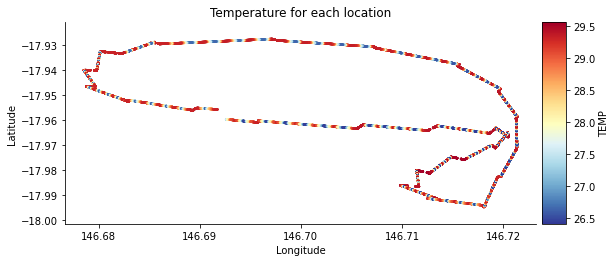

In [37]:
# Create a scatter plot of Temperature vs. Longitude and Latitude
plot = df.hvplot.scatter(
    x='LONGITUDE', 
    y='LATITUDE', 
    c='TEMP', 
    cmap='RdYlBu_r', 
    colorbar=True, 
    title='Temperature for each location',
    xlabel='Longitude',
    ylabel='Latitude'
)
# Display the plot
plot


:Scatter   [TIME]   (DEPTH,TEMP)
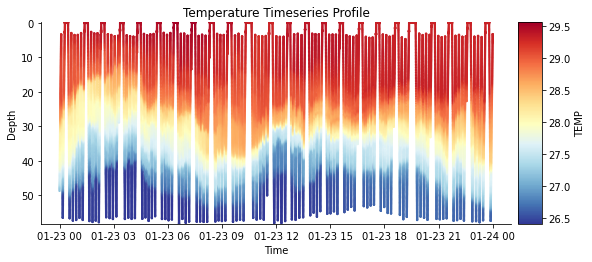

In [38]:
# Create a timeseries profile plot of Temperature vs. Depth over Time
plot = df.hvplot.scatter(
    x='TIME',
    y='DEPTH',
    c='TEMP',
    cmap='RdYlBu_r',
    colorbar=True,
    title='Temperature Timeseries Profile',
    xlabel='Time',
    ylabel='Depth'
)

# Invert y-axis
plot = plot.opts(
    ylim=(df['DEPTH'].max(), df['DEPTH'].min()),  # Invert y-axis
    xlabel='Time',
    ylabel='Depth',
    title='Temperature Timeseries Profile'
)

# Display the plot
plot

# Other methods

## ERDDAP
* Supports searching, subsetting, and downloads in a wide range of formats
* [Example](https://ioos.github.io/ioos_code_lab/content/code_gallery/data_access_notebooks/2016-10-12-fetching_data.html?highlight=erddap)
* Also covered in [this OHW22 tutorial](https://github.com/oceanhackweek/ohw-tutorials/blob/OHW22/01-Tue/00-data-access-in-python/00-data-access.ipynb)

## New OGC APIs
* [New standards](https://ogcapi.ogc.org/#standards) from the Open Geospatial Consortium
* OGC Features (replacement for WFS) - [example](https://github.com/aodn/rimrep-examples/blob/main/Python_based_scripts/ogcfeatures.ipynb)
* OGC Coverages [example](https://github.com/aodn/rimrep-examples/blob/main/Python_based_scripts/ogccoverages.ipynb)

## OGC Web Map Service (WMS)
* Also covered in [this OHW22 tutorial](https://github.com/oceanhackweek/ohw-tutorials/blob/OHW22/01-Tue/00-data-access-in-python/00-data-access.ipynb)

## Further resources
* Lots of data access examples at [IOOS CodeLab](https://ioos.github.io/ioos_code_lab/content/code_gallery/data_access.html)
* Examples in both Python and R from [Reef 2050 Integrated Monitoring and Reporting Program Data Management System (RIMReP DMS)](https://github.com/aodn/rimrep-examples)